In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from InterleavedGCNN import InterleavedGCNN
from GraphDataset import GraphDataset
from train_val_test import train
from parentBCELoss import parentBCELoss

c:\Users\zhay109\.conda\envs\PyG-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Parent ILP

In [2]:
# Load dataset
train_dir = f'./../dataset/training/parent_graphs'
train_data = GraphDataset(root=train_dir, data_list=[])
parents_loader = DataLoader(train_data, batch_size=50, shuffle=True)

In [3]:
data = parents_loader.dataset[0]
data

HeteroData(
  name={ ILP='SC_1.mps' },
  var_nodes={
    x=[542, 3],
    x_sub_opt=[542],
    mask=[542],
    prob_divisor=[1],
    prob_dividend=[1],
    prob=[1],
  },
  constr_nodes={ x=[449, 7] },
  (var_nodes, in, constr_nodes)={
    edge_index=[2, 4413],
    edge_attr=[4413, 1],
  },
  (constr_nodes, rev_in, var_nodes)={
    edge_index=[2, 4413],
    edge_attr=[4413, 1],
  }
)

#### Children ILP

In [4]:
# Load dataset
train_dir = f'./../dataset/training/children_graphs'
train_data = GraphDataset(root=train_dir, data_list=[])
children_loader = DataLoader(train_data, batch_size=50, shuffle=True)

In [5]:
data = children_loader.dataset[0]
data

HeteroData(
  name='SC_10_children_ILP_0.15',
  var_nodes={
    x=[989, 3],
    y=[989],
    mask=[989],
  },
  constr_nodes={ x=[1378, 7] },
  (var_nodes, in, constr_nodes)={
    edge_index=[2, 13837],
    edge_attr=[13837, 1],
  },
  (constr_nodes, rev_in, var_nodes)={
    edge_index=[2, 13837],
    edge_attr=[13837, 1],
  }
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hidden_channels = 64
num_layers = 3

In [9]:
model = InterleavedGCNN(
    var_in_channels=children_loader.dataset[0]["var_nodes"].x.shape[1],
    cons_in_channels=children_loader.dataset[0]["constr_nodes"].x.shape[1],
    hidden_channels=hidden_channels,
    num_layers=num_layers,
    edge_attr_dim=1
).to(device)

# Define loss function and optimizer
criterion = {"children": nn.BCELoss(),
                "parents": nn.BCELoss()}
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Training and validation
num_epochs = 100
train_loss = []
val_loss = []

In [10]:
for epoch in range(1, num_epochs + 1):
    losses = train(model = model, children_loader = children_loader, 
                    parents_loader = parents_loader, 
                    children_criterion = criterion["children"],
                    parents_criterion = criterion["parents"],
                    optimizer = optimizer, device = device)
    train_loss.append(losses[0])
    val_loss.append(losses[1])
    print(f"Epoch: {epoch:02d}, Train Loss: {losses[0]:.4f}, Val Loss: {losses[1]:.4f}")

Epoch: 01, Train Loss: 348.3437, Val Loss: 575.7019
Epoch: 02, Train Loss: 284.5936, Val Loss: 566.5553
Epoch: 03, Train Loss: 276.2597, Val Loss: 565.7458
Epoch: 04, Train Loss: 270.3032, Val Loss: 565.2932
Epoch: 05, Train Loss: 268.8210, Val Loss: 562.5443
Epoch: 06, Train Loss: 268.3063, Val Loss: 562.7139
Epoch: 07, Train Loss: 267.4504, Val Loss: 560.1022
Epoch: 08, Train Loss: 267.3103, Val Loss: 556.7569
Epoch: 09, Train Loss: 268.8058, Val Loss: 555.2390
Epoch: 10, Train Loss: 266.6098, Val Loss: 555.7499
Epoch: 11, Train Loss: 267.9171, Val Loss: 554.4834
Epoch: 12, Train Loss: 263.8702, Val Loss: 554.8519
Epoch: 13, Train Loss: 264.1782, Val Loss: 553.7269
Epoch: 14, Train Loss: 265.7021, Val Loss: 553.9904
Epoch: 15, Train Loss: 262.3757, Val Loss: 554.8988
Epoch: 16, Train Loss: 263.8394, Val Loss: 554.4561
Epoch: 17, Train Loss: 263.5106, Val Loss: 555.2837
Epoch: 18, Train Loss: 261.5053, Val Loss: 554.1922
Epoch: 19, Train Loss: 260.8078, Val Loss: 558.6567
Epoch: 20, T

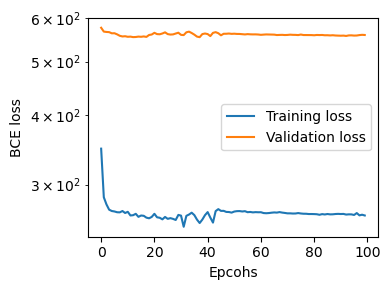

In [11]:
# Save the model
torch.save(model, "./../models/BCE_for_both.pt")


# Save loss plot
plt.figure(figsize=(4, 3))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.xlabel("Epcohs")
plt.ylabel("BCE loss")
plt.yscale("log")
plt.legend()
plt.tight_layout()

plt.savefig("./BCE_for_both.png")
plt.show()
plt.close("all")